# Application: new experiment

This notebook allows users to find specific genes in their experiment of interest using an existing VAE model

This notebook will generate a `generic_gene_summary_<experiment id>.tsv` file that contains a z-score per gene that indicates how specific a gene is the experiment in question.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

In [2]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ponyo import utils
from generic_expression_patterns_modules import process, new_experiment_process, calc

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


## User input

User needs to define the following in the [config file](../configs/config_new_experiment.tsv):

1. Template experiment. This is the experiment you are interested in studying
2. Training compendium used to train VAE, including unnormalized gene mapped version and normalized version
3. Scaler transform used to normalize the training compendium
4. Directory containing trained VAE model
5. Experiment id to label newly create simulated experiments

The user also needs to provide metadata files:
1. `<experiment id>_process_samples.tsv` contains 2 columns (sample ids, label that indicates if the sample is kept or removed). See [example](data/metadata/cis-gem-par-KU1919_process_samples.tsv). **Note: This file is not required if the user wishes to use all the samples in the template experiment file.**
2. `<experiment id>_groups.tsv` contains 2 columns: sample ids, group label to perform DE analysis. See [example](data/metadata/cis-gem-par-KU1919_groups.tsv)

In [3]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_new_experiment.tsv")
)

params = utils.read_config(config_filename)

In [4]:
# Load config params

# Local directory to store intermediate files
local_dir = params['local_dir']

# Number of simulated experiments to generate
num_runs = params['num_simulated']

# Directory containing trained VAE model
vae_model_dir = params['vae_model_dir']

# Dimension of latent space used in VAE model
latent_dim = params['latent_dim']

# ID for template experiment
# This ID will be used to label new simulated experiments
project_id = params['project_id']

# Template experiment filename
template_filename = params['raw_template_filename']
processed_template_filename = params['processed_template_filename']

# Training dataset used for existing VAE model
mapped_compendium_filename = params['mapped_compendium_filename']

# Normalized compendium filename
normalized_compendium_filename = params['normalized_compendium_filename']

# Scaler transform used to scale compendium data into 0-1 range for training
scaler_filename = params['scaler_filename']

# Test statistic used to rank genes by
col_to_rank_genes = params['rank_genes_by']

In [ ]:
# Load metadata files

# Load metadata file with processing information
sample_id_metadata_filename = os.path.join(
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv"
)

# Load metadata file with grouping assignments for samples
metadata_filename = os.path.join(
    "data",
    "metadata",
    f"{project_id}_groups.tsv"
)

In [5]:
# Output filename
gene_summary_filename = f"generic_gene_summary_{project_id}.tsv"

## Process

In [6]:
# Template experiment needs to be of the form sample x gene
transposed_template_filename = "/home/alexandra/Documents/Data/Generic_expression_patterns/Costello_BladderCancer_ResistantCells_Counts_12-8-20_transposed.txt"

new_experiment_process.transpose_save(template_filename, transposed_template_filename)

In [7]:
# Check that the feature space matches between template experiment and VAE model.  
# (i.e. ensure genes in template and VAE model are the same).
mapped_template_experiment = new_experiment_process.compare_match_features(
    transposed_template_filename,
    mapped_compendium_filename
)
mapped_template_filename = transposed_template_filename

(72, 58528)
(49651, 17755)


In [8]:
# Scale template experiment to be within the same range as the
# normalized training dataset used for the VAE model
new_experiment_process.normalize_template_experiment(
    mapped_template_experiment,
    scaler_filename,
    processed_template_filename
)

## Simulate experiments based on template experiment

Embed template experiment into learned latent space and linearly shift template experiment to different locations of the latent space to create new experiments

In [9]:
# Simulate experiments based on template experiment
normalized_data = pd.read_csv(normalized_compendium_filename, sep="\t", index_col=0, header=0)
processed_template_data = pd.read_csv(processed_template_filename, sep="\t", index_col=0, header=0)

for run_id in range(num_runs):
    new_experiment_process.embed_shift_template_experiment(
        normalized_data,
        processed_template_data,
        vae_model_dir,
        project_id,
        scaler_filename,
        local_dir,
        latent_dim,
        run_id
    )

'normalized_data = pd.read_csv(normalized_compendium_filename, sep="\t", index_col=0, header=0)\nprocessed_template_data = pd.read_csv(processed_template_filename, sep="\t", index_col=0, header=0)\n\nfor run_id in range(num_runs):\n    new_experiment_process.embed_shift_template_experiment(\n        normalized_data,\n        processed_template_data,\n        vae_model_dir,\n        project_id,\n        scaler_filename,\n        local_dir,\n        latent_dim,\n        run_id\n    )'

## Differential expression analysis

* If data is RNA-seq then use DESeq2 (using human_general_analysis model)
* If data is microarray then use Limma (using human_cancer_analysis, pseudomonas_analysis models)

In [10]:
# Modify template and simulated experiments based on comparison
if os.path.exists(sample_id_metadata_filename):
    # Read in metadata
    metadata = pd.read_csv(sample_id_metadata_filename, sep='\t', header=0, index_col=0)
    
    # Get samples to be dropped
    sample_ids_to_drop = list(metadata[metadata["processing"] == "drop"].index)

    # Modify simulated experiments
    process.subset_samples(
        sample_ids_to_drop,
        num_runs,
        local_dir,
        project_id
    )
    
    # Modify template experiment
    process.subset_samples_template(
        mapped_template_filename,
        sample_ids_to_drop,
    )

'# Modify template and simulated experiments based on comparison\nif os.path.exists(sample_id_metadata_filename):\n    # Read in metadata\n    metadata = pd.read_csv(sample_id_metadata_filename, sep=\'\t\', header=0, index_col=0)\n    \n    # Get samples to be dropped\n    sample_ids_to_drop = list(metadata[metadata["processing"] == "drop"].index)\n\n    # Modify simulated experiments\n    process.subset_samples(\n        sample_ids_to_drop,\n        num_runs,\n        local_dir,\n        project_id\n    )\n    \n# Modify template experiment\nprocess.subset_samples_template(\n    mapped_template_filename,\n    sample_ids_to_drop,\n)'

In [11]:
# Round simulated and template read counts to int in order to run DESeq.
# This step modifies the following files again:
# "<local_dir>/pseudo_experiments/selected_simulated_data_<project_id>_<n>.txt"
process.recast_int(num_runs, local_dir, project_id)
process.recast_int_template(mapped_template_filename)

'# Round simulated and template read counts to int in order to run DESeq.\n# This step modifies the following files again:\n# "<local_dir>/pseudo_experiments/selected_simulated_data_SRP012656_<n>.txt"\nprocess.recast_int(num_runs, local_dir, project_id)\nprocess.recast_int_template(mapped_template_filename)'

In [13]:
# Check whether ordering of sample ids is consistent between gene expression data and metadata
process.compare_and_reorder_samples(mapped_template_filename, metadata_filename)

# Check whether ordering of sample ids is consistent between gene expression data and metadata
for i in range(num_runs):
    simulated_data_filename = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}.txt"
    )
        
    process.compare_and_reorder_samples(simulated_data_filename, metadata_filename)

sample ids don't match, going to re-order gene expression samples


In [14]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [15]:
%%R -i metadata_filename -i project_id -i mapped_template_filename -i local_dir -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_SRP012656_real.txt"
get_DE_stats_DESeq(metadata_filename,
                   project_id, 
                   mapped_template_filename,
                   "template",
                   local_dir,
                   "real")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarni

[1] "Checking sample ordering..."
[1] TRUE
Error in DESeqDataSet(se, design = design, ignoreRank) : 
  some values in assay are not integers


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘DelayedArray’


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from ‘package:matrixStats’:

    colMaxs, colMins, colRanges, rowMaxs, rowMins, rowRanges


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from ‘package:base’:

    aperm, apply, rowsum


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in DESeqDataSet(se, design = design, ignoreRank) : 
  some values in assay are not integers

  warnings.warn(x, RRuntimeWarning)
/

In [17]:
%%R -i metadata_filename -i project_id -i base_dir -i local_dir -i num_runs

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# Files created: "<local_dir>/DE_stats/DE_stats_simulated_data_SRP012656_<n>.txt"
for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(local_dir, 
                                     "pseudo_experiment/selected_simulated_data_",
                                     project_id,
                                     "_", 
                                     i,
                                     ".txt",
                                     sep = "")
    
    get_DE_stats_DESeq(metadata_filename,
                       project_id, 
                       simulated_data_filename,
                       "simulated",
                       local_dir,
                       i)
}

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarni

[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checki

## Quick validation

Examine volcano plot of the template experiment and example simulated experiments.

In [18]:
# Quick validation
def make_volcano_plot_template(
    template_DE_stats_filename,
    project_id,
):
    
    # Read template DE stats
    template_DE_stats_df = pd.read_csv(
        template_DE_stats_filename,
        sep="\t",
        index_col=0,
        header=0
    )
    
    # Take -log10 of adjusted p-value
    template_DE_stats_df["padj_log10"] = -np.log10(template_DE_stats_df["padj"])

    # Label DEGs by traditional criteria
    # log2FC > 1
    # padj < 0.05
    template_DE_stats_df["gene group"] = "none"
    template_DE_stats_df.loc[(abs(template_DE_stats_df["log2FoldChange"])>1) &
                          (template_DE_stats_df["padj"] <0.05),
                              "gene group"
                         ] = "DEG"

    # Plot
    colors = ["lightgrey", "#2c7fb8"]

    f = sns.scatterplot(
       data=template_DE_stats_df,
        x="log2FoldChange",
        y="padj_log10",
        hue="gene group",
        hue_order=["none", "DEG"],
        style="gene group",
        markers={
            "none": ".",
            "DEG": "o",
        },
        palette=colors,
        linewidth=0,
        alpha=0.5,
        )
    
    f.set_xlabel("log2 Fold Change", fontsize=14, fontname="Verdana")
    f.set_ylabel("-log10(FDR adjusted p-value)", fontsize=14, fontname="Verdana")
    f.set_title(f"Template experiment ({project_id})", fontsize=16, fontname="Verdana")
    
def make_volcano_plot_simulated(
    simulated_DE_stats_dir,
    project_id,
    num_examples
):
    fig, axes = plt.subplots(ncols=num_examples, nrows=1, figsize=(15, 4))
    
    for i in range(num_examples):
        
        # Get filename
        simulated_DE_stats_filename = os.path.join(
            simulated_DE_stats_dir,
            f"DE_stats_simulated_data_{project_id}_{i}.txt"
        )
        
        # Read simulated DE stats
        simulated_DE_stats_df = pd.read_csv(
            simulated_DE_stats_filename,
            sep="\t",
            index_col=0,
            header=0
        )

        # Take -log10 of adjusted p-value
        simulated_DE_stats_df["padj_log10"] = -np.log10(simulated_DE_stats_df["padj"])

        # Label DEGs by traditional criteria
        # log2FC > 1
        # padj < 0.05
        simulated_DE_stats_df["gene group"] = "none"
        simulated_DE_stats_df.loc[(abs(simulated_DE_stats_df["log2FoldChange"])>1) &
                              (simulated_DE_stats_df["padj"] <0.05),
                                  "gene group"
                             ] = "DEG"
        
        # Plot
        colors = ["lightgrey", "#2c7fb8"]
        
        f = sns.scatterplot(
           data=simulated_DE_stats_df,
            x="log2FoldChange",
            y="padj_log10",
            hue="gene group",
            hue_order=["none", "DEG"],
            style="gene group",
            markers={
                "none": ".",
                "DEG": "o",
            },
            palette=colors,
            linewidth=0,
            alpha=0.5,
            legend=False,
            ax=axes[i],
            )
        
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
        
        
    fig.legend(labels=["DEGs", "other genes"], loc='center right')
    fig.text(0.5, 0.0, "log2 Fold Change",ha="center", fontsize=14, fontname="Verdana")
    fig.text(0.08, 0.5, "-log10(FDR adjusted p-value)", va="center", rotation="vertical", fontsize=14, fontname="Verdana")
    fig.suptitle(f"Example simulated experiments based on {project_id}", fontsize=16, fontname="Verdana")

In [19]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

selected = template_DE_stats[(template_DE_stats['padj']<0.01) & (abs(template_DE_stats['log2FoldChange'])>1)]
print(selected.shape)

(1828, 6)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


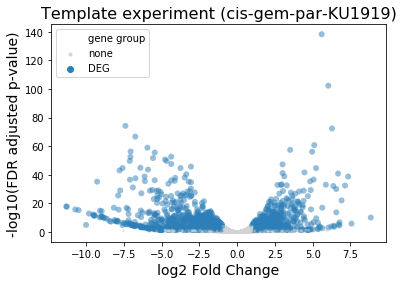

In [20]:
make_volcano_plot_template(
    template_DE_stats_filename,
    project_id,
)

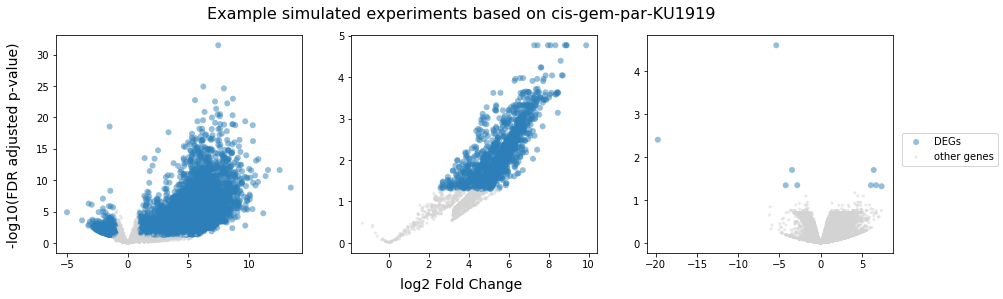

In [21]:
simulated_DE_stats_dir = os.path.join(local_dir, "DE_stats")
num_examples = 3
make_volcano_plot_simulated(
    simulated_DE_stats_dir,
    project_id,
    num_examples
)

## Rank genes

Add description

In [22]:
# Concatenate simulated experiments
simulated_DE_stats_all = process.concat_simulated_data(local_dir, num_runs, project_id, 'DE')

print(simulated_DE_stats_all.shape)

(443875, 7)


In [23]:
# Take absolute value of logFC and t statistic
simulated_DE_stats_all = process.abs_value_stats(simulated_DE_stats_all)

In [24]:
# Aggregate statistics across all simulated experiments
simulated_DE_summary_stats = calc.aggregate_stats(
    col_to_rank_genes,
    simulated_DE_stats_all,
    'DE'
)

In [25]:
# Take absolute value of logFC and t statistic
template_DE_stats = process.abs_value_stats(template_DE_stats)

# Rank genes in template experiment
template_DE_stats = calc.rank_genes_or_pathways(
    col_to_rank_genes,      
    template_DE_stats,
    True
)

In [26]:
# Rank genes in simulated experiments
simulated_DE_summary_stats = calc.rank_genes_or_pathways(
    col_to_rank_genes,
    simulated_DE_summary_stats,
    False
)

## (if needed) Get raw test statistic values

In [ ]:
abs_test_statistics = ["logFC", "log2FoldChange", "t", "NES"]
if test_statistic in abs_test_statistics:
    # Concatenate simulated experiments
    simulated_DE_stats_all_raw = process.concat_simulated_data(local_dir, num_runs, project_id, 'DE')
    
    # Aggregate statistics across all simulated experiments
    simulated_DE_summary_stats_raw = calc.aggregate_stats(
        col_to_rank_genes,
        simulated_DE_stats_all_raw,
        'DE'
    )
    
    # Rank genes in template experiment
    template_DE_stats_raw = calc.rank_genes_or_pathways(
        col_to_rank_genes,      
        template_DE_stats,
        True
    )
    # Rank genes in simulated experiments
    simulated_DE_summary_stats_raw = calc.rank_genes_or_pathways(
        col_to_rank_genes,
        simulated_DE_summary_stats_raw,
        False
    )
    summary_gene_ranks_raw = process.generate_summary_table(
        template_DE_stats_raw,
        simulated_DE_summary_stats_raw,
        col_to_rank_genes,
        local_dir,
        'gene',
        params
    )

## Summary table

Description of table columns

In [27]:
# Get summary table
summary_gene_ranks = process.generate_summary_table(
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir,
    'gene',
    params
)

summary_gene_ranks.sort_values(by="abs(Z score)", ascending=False).head(10)

(17755, 13)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),Median adj p-value (simulated),Rank (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),abs(Z score)
ZNF71,ZNF71,2.038134e-18,2.0,-11.296237,0.609892,6091.0,0.878700,1.574915,25,7.730533
PIK3CG,PIK3CG,4.662827e-09,24.0,-8.113635,0.383659,12131.0,1.708624,1.289122,25,7.619341
ZNF334,ZNF334,5.987626e-16,4.0,-10.507864,0.354646,10261.0,1.241783,1.884017,25,6.236487
PCDH17,PCDH17,2.072506e-16,3.0,-10.721939,0.616271,7219.0,1.019821,1.932895,23,6.074700
ZFP28,ZFP28,1.449637e-10,18.0,-8.846543,0.683240,5883.0,0.382400,1.553579,25,5.940441
TCF15,TCF15,2.749885e-11,15.0,-8.988289,0.312529,11199.0,1.387875,1.888204,24,5.495255
CDO1,CDO1,3.409048e-26,30.0,-7.879918,0.259514,13078.0,2.034902,1.824863,25,5.433186
MC4R,MC4R,1.604733e-05,55.0,-6.967749,0.029612,15844.0,2.962835,1.828849,18,5.429965
ACSS3,ACSS3,1.692357e-10,19.0,-8.778948,0.410534,11198.0,1.491059,1.916257,25,5.359410
KCNA4,KCNA4,6.916909e-04,80.0,-6.316240,0.408755,12824.0,1.726283,1.502893,18,5.351362


In [ ]:
# Create 

In [29]:
# Save
summary_gene_ranks.to_csv(gene_summary_filename, sep='\t')